In [1]:
from Dataset import ShapeNetWithPrompts
from plot_image_grid import image_grid

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import pytorch3d as pt3
from pytorch3d.datasets import collate_batched_meshes, render_cubified_voxels
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform
)


import os
from tqdm import tqdm
import json
import datetime
import numpy as np

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(f'Running on {device}')

Running on cuda:0


## **Configuration**

In [2]:
CONFIG = {
    "data": {
        "dataset_name": "shapenet",
        "dataset_train_path": "data/train",
        "dataset_test_path": "data/test",
        "prompt_csv_path": "data/model_descriptions_5_cat.csv",
        "classes_to_extract" : ["bottle", "bowl", "laptop", "mug", "skateboard"]
    },
    "text_embedder": {
        "model_name": "distilbert-base-uncased",
        "max_length": 256,
    },
    "diffusion": {
        "IN_CHANNELS": 1,
        "OUT_CHANNELS": 1,
        "TIME_EMBEDDING_DIM": 128,
        "TIMESTEPS": 800,
        "beta_start": 0.0001,
        "beta_end": 0.02,
        "unet_dim": 64,
        "unet_dim_mults": (1, 2, 4, 8),
        "log_path": "conditional_diffusion_training_log.json",
        "model_path_best_conditional": "diffusion_conditional_hf_transformer_best.pth",
        "model_path_best_baseline": "diffusion_baseline_hf_best.pth"
    },
    "sampling": {
        "output_dir": "generated_models",
        "num_samples": 5,
    },
    "training_parameters":{
        "num_epochs": 32,
        "batch_size": 32,
        "learning_rate": 1e-4,
        "optimizer": "AdamW",
        "weight_decay": 1e-4,
        "loss": "l2",
        "num_workers": 4,
        "num_genres": 5,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "checkpoint_path": "model_checkpoints",
        "metric_store_path": "prompt_diffusion_training_log.json",
        "checkpoint_interval": 5,
    }
}

os.makedirs(CONFIG["sampling"]["output_dir"], exist_ok=True)


## **Setup Dataset and DataLoader**

In [3]:
train_dataset = ShapeNetWithPrompts(CONFIG["data"]["dataset_train_path"], CONFIG["data"]["prompt_csv_path"], synsets=CONFIG["data"]["classes_to_extract"], split="train")
val_dataset = ShapeNetWithPrompts(CONFIG["data"]["dataset_test_path"], CONFIG["data"]["prompt_csv_path"], synsets=CONFIG["data"]["classes_to_extract"], split="val")

C:\Users\Faizan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:116: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location data/train: 02946921, 03761084, 03325088, 03710193, 02871439, 03001627, 03624134, 04401088, 03207941, 02933112, 03593526, 03991062, 04379243, 03513137, 04554684, 04074963, 04468005, 02828884, 02773838, 03337140, 03046257, 04530566, 03261776, 02924116, 02801938, 04090263, 04330267, 02691156, 02992529, 03928116, 02808440, 03211117, 04004475, 03085013, 03691459, 02818832, 03948459, 02747177, 04256520, 03636649, 02954340, 03790512, 04460130, 02958343, 02843684, 03467517, 03759954, 03938244, 04099429, 02942699
  warnings.warn(msg)
C:\Users\Faizan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch3

In [6]:
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

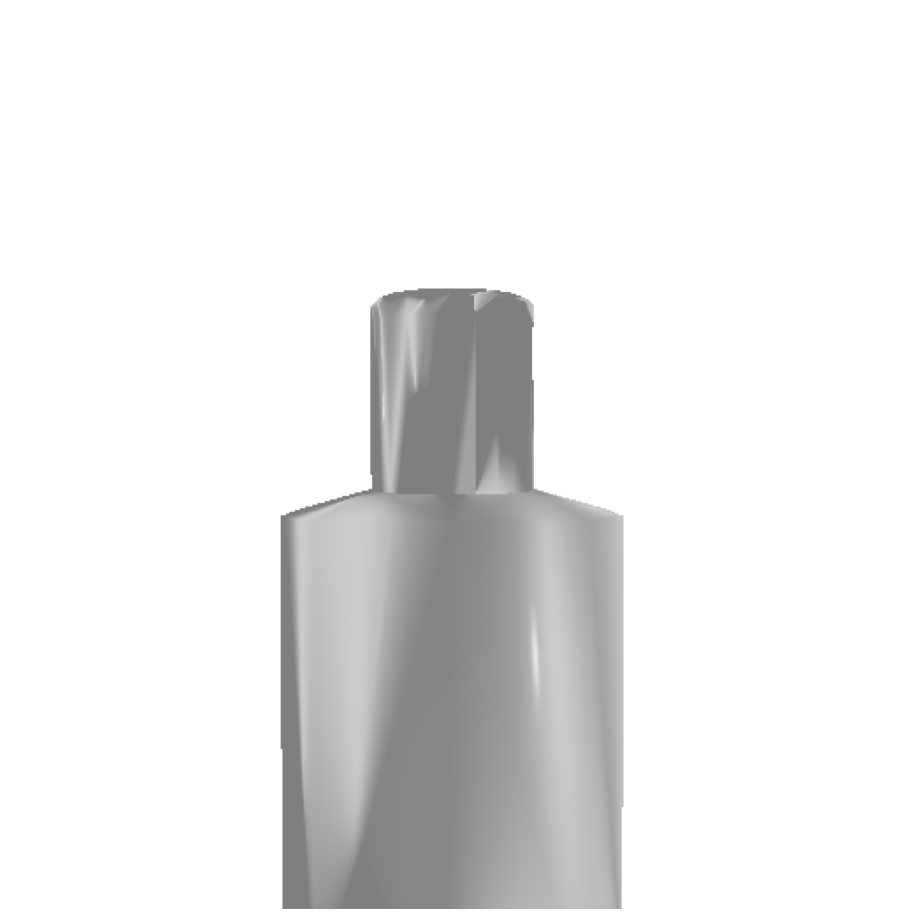

In [7]:
images_by_model_id = train_dataset.render(0, cameras=cameras, raster_settings=raster_settings, lights=lights, device=device)
image_grid(images_by_model_id.cpu().numpy(), rows=1, cols=1, rgb=True, show_axes=False)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["training_parameters"]["batch_size"],
    shuffle=True,
    num_workers=CONFIG["training_parameters"]["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["training_parameters"]["batch_size"],
    shuffle=False,
    num_workers=CONFIG["training_parameters"]["num_workers"],
    pin_memory=True
)

## **Prompt Conditioned Diffusion**

### **Load Encoder and Diffusion Models**

In [9]:
from transformers import AutoTokenizer, AutoModel
from Diffusion import DiffusionProcess, UNetPromptConditional3D

In [10]:
prompt_model_name = CONFIG["text_embedder"]["model_name"]
prompt_tokenizer = AutoTokenizer.from_pretrained(prompt_model_name, device_map="auto")
prompt_model = AutoModel.from_pretrained(prompt_model_name)

In [11]:
model = UNetPromptConditional3D(
        in_channels=CONFIG["diffusion"]["IN_CHANNELS"],
        out_channels=CONFIG["diffusion"]["OUT_CHANNELS"],
        prompt_tokenizer=prompt_tokenizer,
        prompt_embedder=prompt_model,
        dim=64,
        dim_mults=(1, 2, 4), # Fewer levels might be needed for memory
        time_embed_dim=CONFIG["diffusion"]["TIME_EMBEDDING_DIM"],
        dropout=0.1,
        device=device
    ).to(device)

diffusion = DiffusionProcess(timesteps=CONFIG["diffusion"]["TIMESTEPS"], device=device, beta_schedule='cosine')

print(f"U-Net Model parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

U-Net Model parameter count: 87,756,097


### **Training Loop**

In [ ]:
def train(cfg):
    
    # Setup Device
    print(f"Using device for training: {device}")

    check_point_path = cfg["training_parameters"]["checkpoint_path"]
    log_file_path = cfg["training_parameters"]["metric_store_path"]

    # Create Checkpoint Directory
    os.makedirs(check_point_path, exist_ok=True)

    # Create Directory to store performace
    os.makedirs(log_file_path, exist_ok=True)
    
    print(f"--- Training Diffusion Model for 3D model generation ---")
    print(f"Logging metrics to: {log_file_path}")
    print(f"Saving latest model to: {check_point_path}")
    
    training_logs = []

    optimizer = optim.AdamW(model.parameters(), lr=cfg["training_parameters"]["learning_rate"], weight_decay=cfg["training_parameters"]["weight_decay"])
    
    print("Starting Training...")
    epoch_iterator = tqdm(range(cfg["training_parameters"]["num_epochs"]), desc="Epochs", leave=True)
    for epoch in tqdm(epoch_iterator):
        model.train() # Set U-Net to training mode
        total_train_loss = 0.0

        for step, (voxels, prompts, _, _) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Prepare batch data
            x_start = voxels.to(device)  # Shape: (batch_size, 32, 32, 32, 32)
            # Ensure batch sizes match
            current_batch_size = x_start.shape[0]
            if len(prompts) != current_batch_size:
                 raise RuntimeError(f"Batch size mismatch: Voxels {current_batch_size}, Prompts {len(prompts)}")
                 
            # Sample random timesteps
            t = torch.randint(0, cfg["diffusion"]["TIMESTEPS"], (current_batch_size,), device=device).long()

            # Calculate loss
            loss = diffusion.p_losses(model, x_start, t, prompts, loss_type=cfg["training_parameters"]["loss"])

            # Backpropagation
            loss.backward()


            optimizer.step()

            total_train_loss += loss.item()
    

        avg_train_loss = total_train_loss / len(train_loader)
        
        model.eval()
        total_val_loss = 0.0
        
        with torch.no_grad(): # Disable gradient calculations for validation
            for step, (voxels, prompts, _, _) in enumerate(val_loader):
                
                x_start = voxels.to(device)
                current_batch_size = x_start.shape[0]
                if len(prompts) != current_batch_size:
                 raise RuntimeError(f"Batch size mismatch: Voxels {current_batch_size}, Prompts {len(prompts)}")
                 

                t = torch.randint(0, cfg["diffusion"]["TIMESTEPS"], (current_batch_size,), device=device).long()

                # Calculate validation loss (use same method as training)
                loss = diffusion.p_losses(model, x_start, t, prompts, loss_type=cfg["training_parameters"]["loss"])
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


        # Save Checkpoint
        if (epoch + 1) % cfg["training_parameters"]["checkpoint_interval"] == 0 or (epoch + 1) == cfg["training_parameters"]["num_epochs"]:
            checkpoint_path = os.path.join(cfg["training_parameters"]["checkpoint_path"], f"unet_epoch_{epoch+1}.pth")
            try:
                torch.save(model.state_dict(), checkpoint_path)
                print(f"Checkpoint saved to {checkpoint_path}")
            except Exception as e:
                print(f"Error saving checkpoint: {e}")


        epoch_metrics = {
            "epoch": epoch + 1,
            "timestamp": datetime.datetime.now(datetime.timezone.utc).isoformat(),
            "avg_train_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "learning_rate": cfg["training_parameters"]["learning_rate"] #scheduler.get_last_lr()[0] if scheduler else cfg["training_parameters"]["learning_rate"],
        }

        training_logs.append(epoch_metrics)

    print("Training Finished.")


    try:
        with open(cfg["training_parameters"]["checkpoint_path"], 'w') as f:
            json.dump(training_logs, f, indent=4)
        print(f"Training metrics saved to {cfg["training_parameters"]["checkpoint_path"]}")
    except Exception as e:
        print(f"Error saving metrics JSON: {e}")

    return training_logs


In [12]:
train(CONFIG)

Using device for training: cuda:0
--- Training Diffusion Model for 3D model generation ---
Logging metrics to: prompt_diffusion_training_log.json
Saving latest model to: model_checkpoints
Starting Training...


Epochs:   3%|▎         | 1/32 [02:02<1:03:05, 122.12s/it]

Epoch 1: Train Loss: 0.3961, Val Loss: 0.4238


Epoch 2: Train Loss: 0.1360, Val Loss: 0.1289


Epochs:   9%|▉         | 3/32 [06:06<58:36, 121.26s/it]  

Epoch 3: Train Loss: 0.1072, Val Loss: 0.0826


Epochs:  12%|█▎        | 4/32 [08:10<57:04, 122.32s/it]

Epoch 4: Train Loss: 0.1052, Val Loss: 0.1059
Epoch 5: Train Loss: 0.0916, Val Loss: 0.0919


Epochs:  16%|█▌        | 5/32 [10:14<55:17, 122.87s/it]

Checkpoint saved to model_checkpoints\unet_epoch_5.pth


Epochs:  19%|█▉        | 6/32 [12:17<53:14, 122.87s/it]

Epoch 6: Train Loss: 0.0923, Val Loss: 0.0688


Epochs:  22%|██▏       | 7/32 [14:10<49:57, 119.90s/it]

Epoch 7: Train Loss: 0.0953, Val Loss: 0.1003


Epochs:  25%|██▌       | 8/32 [16:05<47:14, 118.09s/it]

Epoch 8: Train Loss: 0.0818, Val Loss: 0.0993


Epochs:  28%|██▊       | 9/32 [17:53<44:08, 115.15s/it]

Epoch 9: Train Loss: 0.0902, Val Loss: 0.0572
Epoch 10: Train Loss: 0.0802, Val Loss: 0.0690


Epochs:  31%|███▏      | 10/32 [19:53<42:45, 116.59s/it]

Checkpoint saved to model_checkpoints\unet_epoch_10.pth


Epochs:  34%|███▍      | 11/32 [21:42<40:01, 114.36s/it]

Epoch 11: Train Loss: 0.0779, Val Loss: 0.0735


Epochs:  38%|███▊      | 12/32 [23:42<38:37, 115.89s/it]

Epoch 12: Train Loss: 0.0771, Val Loss: 0.0789


Epochs:  41%|████      | 13/32 [25:39<36:51, 116.39s/it]

Epoch 13: Train Loss: 0.0790, Val Loss: 0.0701


Epochs:  44%|████▍     | 14/32 [27:32<34:33, 115.17s/it]

Epoch 14: Train Loss: 0.0810, Val Loss: 0.0559
Epoch 15: Train Loss: 0.0700, Val Loss: 0.0732


Epochs:  47%|████▋     | 15/32 [29:30<32:53, 116.09s/it]

Checkpoint saved to model_checkpoints\unet_epoch_15.pth


Epochs:  50%|█████     | 16/32 [31:19<30:22, 113.94s/it]

Epoch 16: Train Loss: 0.0733, Val Loss: 0.0646


Epochs:  53%|█████▎    | 17/32 [33:12<28:24, 113.63s/it]

Epoch 17: Train Loss: 0.0762, Val Loss: 0.0680


Epochs:  56%|█████▋    | 18/32 [35:05<26:27, 113.43s/it]

Epoch 18: Train Loss: 0.0705, Val Loss: 0.0572


Epochs:  59%|█████▉    | 19/32 [36:56<24:24, 112.63s/it]

Epoch 19: Train Loss: 0.0659, Val Loss: 0.0754
Epoch 20: Train Loss: 0.0596, Val Loss: 0.0597


Epochs:  62%|██████▎   | 20/32 [38:54<22:52, 114.37s/it]

Checkpoint saved to model_checkpoints\unet_epoch_20.pth


Epochs:  66%|██████▌   | 21/32 [40:42<20:37, 112.49s/it]

Epoch 21: Train Loss: 0.0672, Val Loss: 0.0580


Epochs:  69%|██████▉   | 22/32 [42:38<18:55, 113.53s/it]

Epoch 22: Train Loss: 0.0642, Val Loss: 0.0664


Epochs:  72%|███████▏  | 23/32 [44:31<17:01, 113.49s/it]

Epoch 23: Train Loss: 0.0606, Val Loss: 0.0522


Epochs:  75%|███████▌  | 24/32 [46:19<14:53, 111.64s/it]

Epoch 24: Train Loss: 0.0589, Val Loss: 0.0494
Epoch 25: Train Loss: 0.0573, Val Loss: 0.0623


Epochs:  78%|███████▊  | 25/32 [48:11<13:03, 111.96s/it]

Checkpoint saved to model_checkpoints\unet_epoch_25.pth


Epochs:  81%|████████▏ | 26/32 [50:13<11:28, 114.75s/it]

Epoch 26: Train Loss: 0.0594, Val Loss: 0.0610


Epochs:  84%|████████▍ | 27/32 [52:03<09:27, 113.49s/it]

Epoch 27: Train Loss: 0.0605, Val Loss: 0.0487


Epochs:  88%|████████▊ | 28/32 [53:57<07:34, 113.51s/it]

Epoch 28: Train Loss: 0.0664, Val Loss: 0.0621


Epochs:  91%|█████████ | 29/32 [55:59<05:48, 116.23s/it]

Epoch 29: Train Loss: 0.0610, Val Loss: 0.0496
Epoch 30: Train Loss: 0.0593, Val Loss: 0.0388


Epochs:  94%|█████████▍| 30/32 [58:02<03:56, 118.08s/it]

Checkpoint saved to model_checkpoints\unet_epoch_30.pth


Epochs:  97%|█████████▋| 31/32 [59:57<01:57, 117.18s/it]

Epoch 31: Train Loss: 0.0609, Val Loss: 0.0549
Epoch 32: Train Loss: 0.0580, Val Loss: 0.0552


100%|██████████| 32/32 [1:01:48<00:00, 115.89s/it]

Checkpoint saved to model_checkpoints\unet_epoch_32.pth
Training Finished.
Error saving metrics JSON: [Errno 13] Permission denied: 'model_checkpoints'


[{'epoch': 1,
  'timestamp': '2025-04-23T08:48:00.720630+00:00',
  'avg_train_loss': 0.3961170855909586,
  'avg_val_loss': 0.4237687811255455,
  'learning_rate': 0.0001},
 {'epoch': 2,
  'timestamp': '2025-04-23T08:50:08.990906+00:00',
  'avg_train_loss': 0.1360477632842958,
  'avg_val_loss': 0.12891476228833199,
  'learning_rate': 0.0001},
 {'epoch': 3,
  'timestamp': '2025-04-23T08:52:05.127923+00:00',
  'avg_train_loss': 0.10723248310387135,
  'avg_val_loss': 0.08259428478777409,
  'learning_rate': 0.0001},
 {'epoch': 4,
  'timestamp': '2025-04-23T08:54:09.072473+00:00',
  'avg_train_loss': 0.1051947707310319,
  'avg_val_loss': 0.10588918626308441,
  'learning_rate': 0.0001},
 {'epoch': 5,
  'timestamp': '2025-04-23T08:56:12.922545+00:00',
  'avg_train_loss': 0.09155627759173512,
  'avg_val_loss': 0.09191924706101418,
  'learning_rate': 0.0001},
 {'epoch': 6,
  'timestamp': '2025-04-23T08:58:15.791943+00:00',
  'avg_train_loss': 0.09232843923382461,
  'avg_val_loss': 0.0688221966847

## **Sampling**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_voxel_grid(voxel_path):
    voxel_data = torch.load(voxel_path, map_location='cpu')  # Load on CPU

    if isinstance(voxel_data, dict):
        voxel_tensor = voxel_data.get('voxel', None)  # Adjust key if needed
    else:
        voxel_tensor = voxel_data

    voxel_np = voxel_tensor.detach().cpu().numpy()  # Shape: (D, H, W)

    threshold = 0.5  # Adjust as needed
    voxel_binary = (voxel_np > threshold).astype(np.float32)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    _, x, y, z = np.where(voxel_binary)

    ax.scatter(x, y, z, c='blue', marker='o', s=10, alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Voxel Grid Visualization')

    plt.tight_layout()
    plt.show()
   

In [ ]:
def sample_diffusion(config, prompt, model_path):
    print(f"--- Sampling from Diffusion Model")
    print(f"Loading model from: {model_path}")
    
    diffusion = DiffusionProcess(timesteps=CONFIG["diffusion"]["TIMESTEPS"], device=device, beta_schedule='cosine')

    unet_model = UNetPromptConditional3D(in_channels=config["diffusion"]["IN_CHANNELS"], out_channels=config["diffusion"]["OUT_CHANNELS"],
        prompt_tokenizer=prompt_tokenizer, prompt_embedder=prompt_model, dim=64, dim_mults=(1, 2, 4), time_embed_dim=config["diffusion"]["TIME_EMBEDDING_DIM"],
        dropout=0.1, device=device).to(device)
    try:
        unet_model.load_state_dict(torch.load(model_path, map_location=device))
        unet_model.eval()
        print("Diffusion model loaded successfully.")
    except FileNotFoundError:
         print(f"ERROR: Diffusion model weights not found at {model_path}. Please train the model first.")
         return
    except Exception as e:
        print(f"Error loading diffusion model weights: {e}")
        return
    print("Generating samples...")
    generated_model_list = diffusion.sample(
        unet_model,
        shape=(1, 32, 32, 32), 
        prompts=prompt,
    )
    final_model = generated_model_list[-1] # 
    spec = final_model 
    filename = "model_1.pth"
    save_path = os.path.join(config["sampling"]["output_dir"], filename)
    torch.save(spec, save_path)
    print(f"Saved generated spectrogram to {save_path}")
    print("Sampling finished.")
    return save_path


In [ ]:

from skimage import measure

def save_mesh_obj(vertices, faces, filepath):
    print(f"Saving mesh to {filepath}...")
    try:
        with open(filepath, 'w') as f:
            # Write vertices (v x y z)
            for v in vertices:
                f.write(f"v {v[0]:.6f} {v[1]:.6f} {v[2]:.6f}\n")

            # Write faces (f v1 v2 v3) - OBJ format uses 1-based indexing
            for face in faces:
                f.write(f"f {face[0] + 1} {face[1] + 1} {face[2] + 1}\n")
        print("Mesh saved successfully.")
    except Exception as e:
        print(f"Error saving mesh to {filepath}: {e}")

def pth_to_mesh(pth_filepath, obj_filepath, isolevel=0.5, tensor_key=None):
    print(f"Loading voxel data from: {pth_filepath}")
    if not os.path.exists(pth_filepath):
        print(f"Error: Input file not found at {pth_filepath}")
        return
    try:
        data = torch.load(pth_filepath, map_location=torch.device('cpu'))
        voxel_tensor = None
        if isinstance(data, torch.Tensor):
            voxel_tensor = data
            print("Loaded data is a direct tensor.")
        elif isinstance(data, dict):
            print(f"Loaded data is a dictionary. Keys: {list(data.keys())}")
            if tensor_key:
                if tensor_key in data:
                    if isinstance(data[tensor_key], torch.Tensor):
                        voxel_tensor = data[tensor_key]
                        print(f"Using tensor found with key: '{tensor_key}'")
                    else:
                        print(f"Error: Value for key '{tensor_key}' is not a tensor.")
                        return
                else:
                    print(f"Error: Key '{tensor_key}' not found in the dictionary.")
                    return
            else:
                for key, value in data.items():
                    if isinstance(value, torch.Tensor):
                        print(f"No key specified, using the first tensor found with key: '{key}'")
                        voxel_tensor = value
                        break
                if voxel_tensor is None:
                    print("Error: No tensor found in the dictionary and no tensor_key specified.")
                    return
        else:
            print(f"Error: Loaded data type ({type(data)}) is not a Tensor or a dictionary containing a Tensor.")
            return

        if voxel_tensor is None:
             print("Error: Could not extract voxel tensor.")
             return

        print(f"Voxel tensor shape: {voxel_tensor.shape}")
        print(f"Voxel tensor data type: {voxel_tensor.dtype}")

        voxel_data = voxel_tensor.numpy()

        if voxel_data.ndim != 3:
            original_shape = voxel_data.shape
            voxel_data = np.squeeze(voxel_data)
            if voxel_data.ndim != 3:
                 print(f"Error: Voxel data must be 3-dimensional, but got shape {original_shape} (squeezed to {voxel_data.shape}). Cannot apply marching cubes.")
                 return
            else:
                 print(f"Squeezed tensor shape from {original_shape} to {voxel_data.shape}")

        if not np.issubdtype(voxel_data.dtype, np.number):
             print(f"Warning: Voxel data type is {voxel_data.dtype}. Attempting to convert to float32.")
             try:
                 voxel_data = voxel_data.astype(np.float32)
             except ValueError:
                 print("Error: Could not convert voxel data to a numeric type.")
                 return

        print(f"Running marching cubes with isolevel = {isolevel}...")

        try:
            vertices, faces, normals, values = measure.marching_cubes(
                volume=voxel_data,
                level=isolevel,
                spacing=(1.0, 1.0, 1.0) # Adjust if voxel spacing is different
            )
        except Exception as e:
            print(f"Error during marching cubes execution: {e}")
            if np.all(voxel_data <= isolevel) or np.all(voxel_data >= isolevel):
                 print("Hint: The entire volume is above or below the isolevel. No surface generated.")
            return


        print(f"Generated mesh: {len(vertices)} vertices, {len(faces)} faces.")

        if len(vertices) == 0 or len(faces) == 0:
            print("Warning: Marching cubes did not produce any vertices or faces. Check the isolevel and voxel data.")
            return

        save_mesh_obj(vertices, faces, obj_filepath)

    except FileNotFoundError:
        print(f"Error: File not found at {pth_filepath}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()


In [ ]:
import open3d as o3d

def visualize_mesh(obj_filepath):
    """
    Loads and visualizes a mesh from an .obj file using Open3D.

    Args:
        obj_filepath (str): Path to the input .obj mesh file.
    """
    print(f"Attempting to load mesh from: {obj_filepath}")

    if not os.path.exists(obj_filepath):
        print(f"Error: Input file not found at {obj_filepath}")
        return

    try:
        # Read the mesh file using Open3D
        # print_progress=True shows loading progress in the console
        mesh = o3d.io.read_triangle_mesh(obj_filepath, print_progress=True)

        if not mesh.has_vertices():
            print(f"Error: The file {obj_filepath} loaded successfully, but it contains no vertices.")
            return
        if not mesh.has_triangles():
             print(f"Warning: The file {obj_filepath} loaded successfully, but it contains no triangles (faces). Displaying point cloud instead.")
             # Optionally, visualize just the vertices as a point cloud
             pcd = o3d.geometry.PointCloud()
             pcd.points = mesh.vertices
             if mesh.has_vertex_colors():
                 pcd.colors = mesh.vertex_colors
             elif mesh.has_vertex_normals():
                 # Color based on normals if available
                 pcd.colors = o3d.utility.Vector3dVector(np.abs(np.asarray(mesh.vertex_normals)))

             print("Visualizing vertices as point cloud...")
             o3d.visualization.draw_geometries([pcd], window_name=f"Mesh Vertices: {os.path.basename(obj_filepath)}")
             return


        print(f"Successfully loaded mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles.")

        # --- Mesh Preprocessing (Optional but Recommended) ---
        # 1. Compute vertex normals if they are not present in the file
        #    This is essential for proper shading/lighting.
        if not mesh.has_vertex_normals():
            print("Computing vertex normals...")
            mesh.compute_vertex_normals()

        # 2. Compute triangle normals (less common to need explicitly, but good practice)
        if not mesh.has_triangle_normals():
             mesh.compute_triangle_normals() # Often computed implicitly by renderers

        # 3. Center the mesh (optional, makes viewing easier)
        # center = mesh.get_center()
        # mesh.translate(-center, relative=False)
        # print(f"Mesh centered around origin.")

        # --- Visualization ---
        print("Launching Open3D visualizer...")
        # draw_geometries displays the mesh in an interactive window
        # You can rotate (left mouse drag), zoom (scroll), and pan (shift + left mouse drag)
        o3d.visualization.draw_geometries(
            [mesh],                               # List of geometries to draw
            window_name=f"Mesh Visualization: {os.path.basename(obj_filepath)}",
            width=800,                            # Window width
            height=600,                           # Window height
            mesh_show_wireframe=False,            # Set to True to see the wireframe
            mesh_show_back_face=False             # Set to True to render back faces (useful for non-watertight meshes)
        )
        print("Visualizer window closed.")

    except Exception as e:
        print(f"An error occurred during mesh loading or visualization: {e}")
        import traceback
        traceback.print_exc()


In [16]:
def sample_and_visualize(config, prompt, model_path):
    """
    Sample a 3D model from the diffusion model and visualize it.

    Args:
        config (dict): Configuration dictionary.
        prompt (str): Text prompt for the diffusion model.
        model_path (str): Path to the trained diffusion model weights.
    """
    # Sample the diffusion model
    voxel_path = sample_diffusion(config, prompt, model_path)
    visualize_voxel_grid(voxel_path)
    
    # Convert the generated .pth file to .obj and visualize it
    pth_file = os.path.join(config["sampling"]["output_dir"], "model_1.pth")
    obj_file = os.path.join(config["sampling"]["output_dir"], "output_mesh.obj")
    pth_to_mesh(pth_file, obj_file, isolevel=0.0, tensor_key='voxel_data') # Adjust isolevel and key if needed

    # Visualize the generated mesh
    visualize_mesh(obj_file)

--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


C:\Users\Faizan\AppData\Local\Temp\ipykernel_20616\1962826730.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(model_path, map_loca

Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


C:\Users\Faizan\AppData\Local\Temp\ipykernel_20616\3059974095.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  voxel_data = torch.load(voxel_path, map_location='cpu')  # 

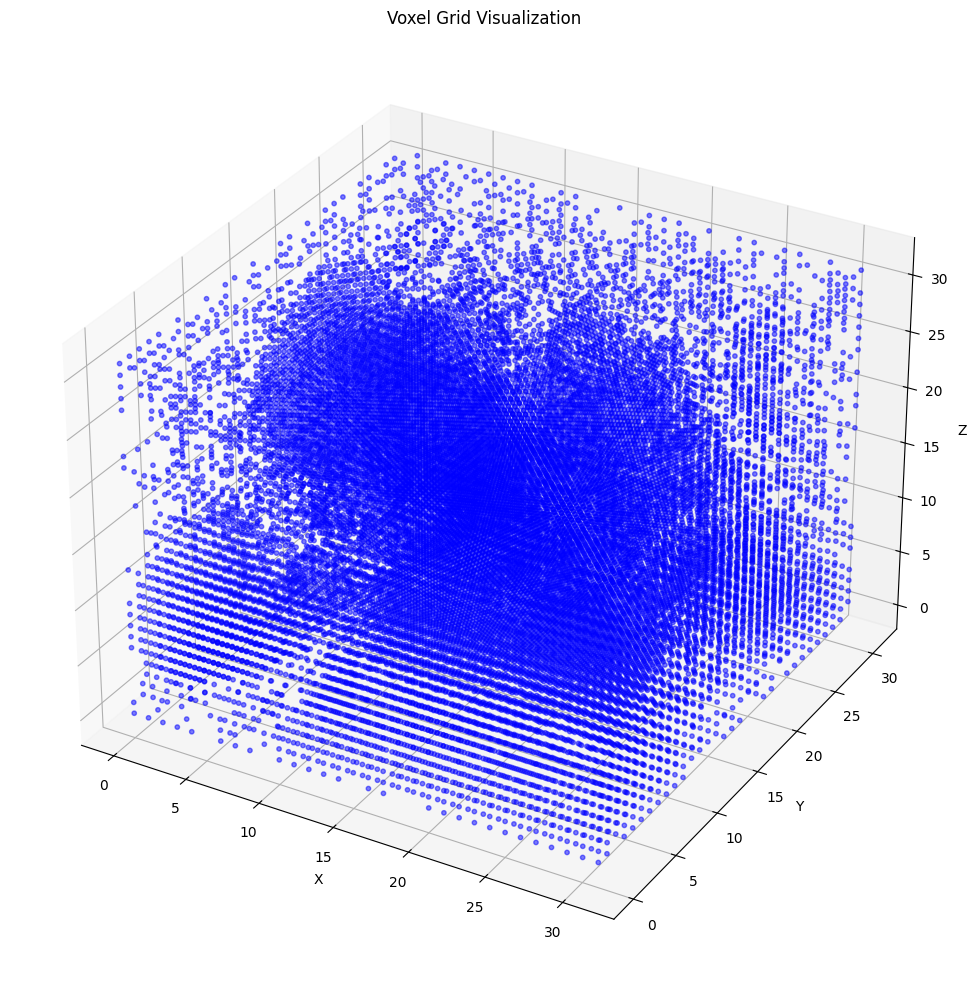

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 21858 vertices, 42247 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 21858 vertices, 42247 triangles.
Computing vertex normals...
Launching Open3D visualizer...


C:\Users\Faizan\AppData\Local\Temp\ipykernel_20616\3637908280.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pth_filepath, map_location=torch.device(

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
Visualizer window closed.
Prompt: ['a bottle with a long neck']
--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


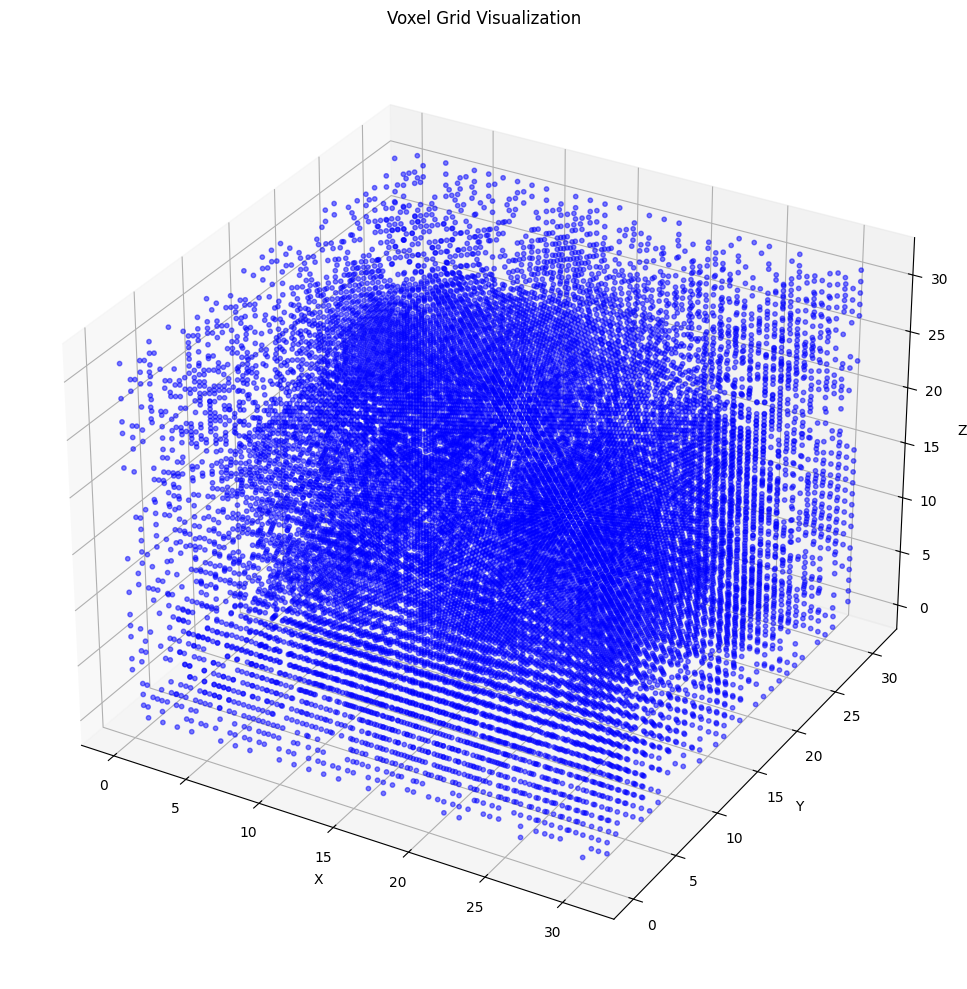

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 29047 vertices, 57229 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 29047 vertices, 57229 triangles.
Computing vertex normals...
Launching Open3D visualizer...
Visualizer window closed.
Prompt: ['A bottle with a long neck']
--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


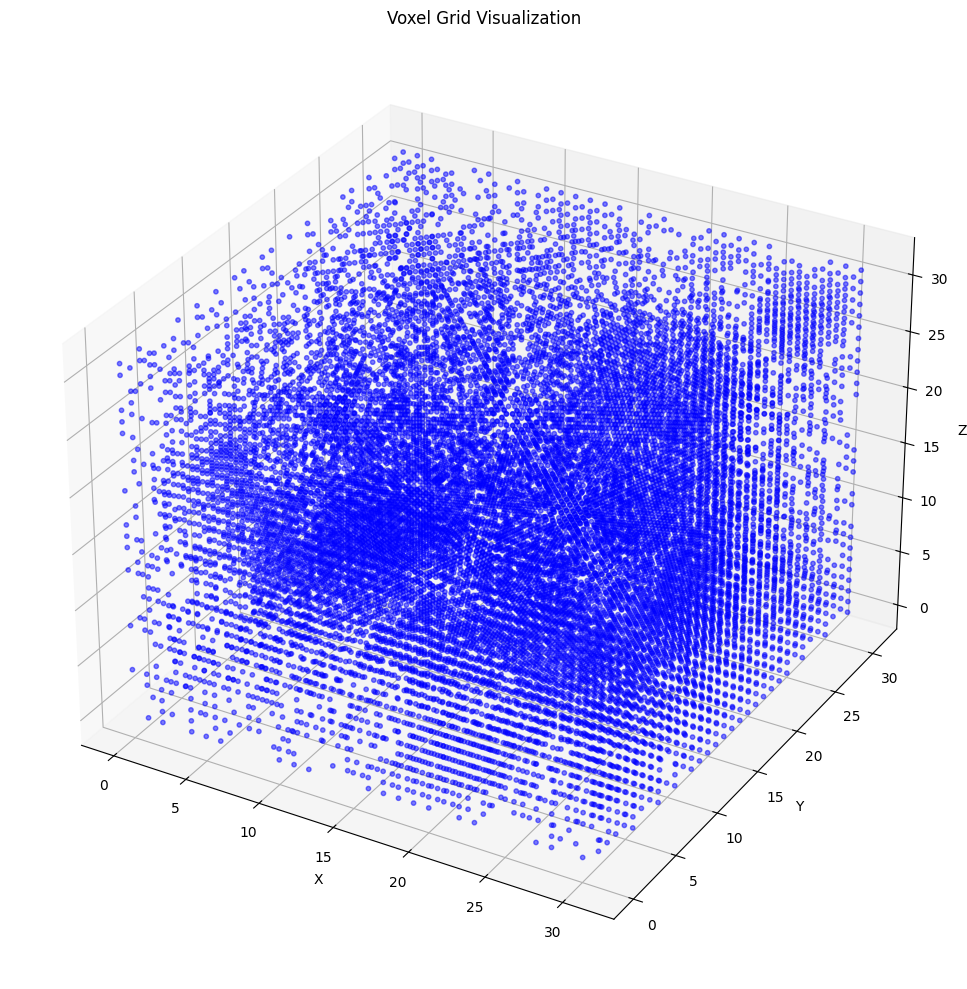

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 33426 vertices, 66513 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 33426 vertices, 66513 triangles.
Computing vertex normals...
Launching Open3D visualizer...
Visualizer window closed.
Prompt: ['A long skateboard']
--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


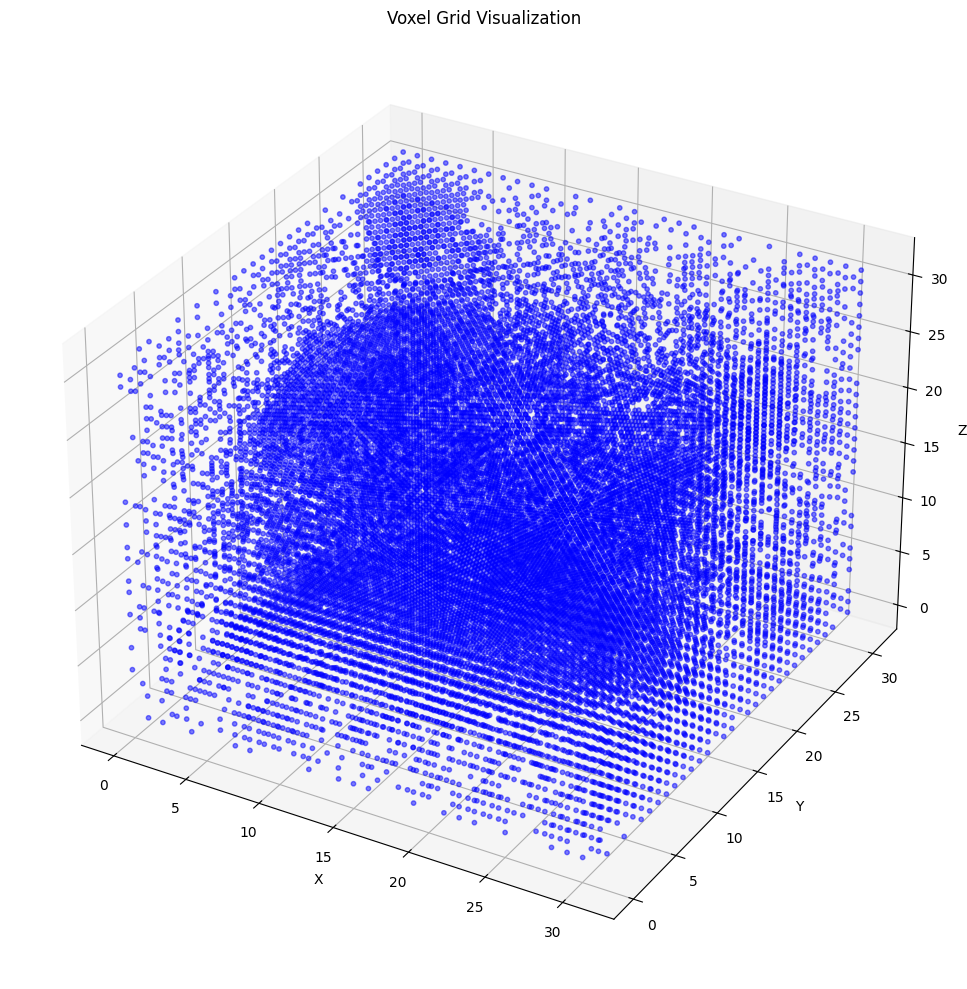

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 28617 vertices, 56240 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 28617 vertices, 56240 triangles.
Computing vertex normals...
Launching Open3D visualizer...
Visualizer window closed.
Prompt: ['A circle bottle']
--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


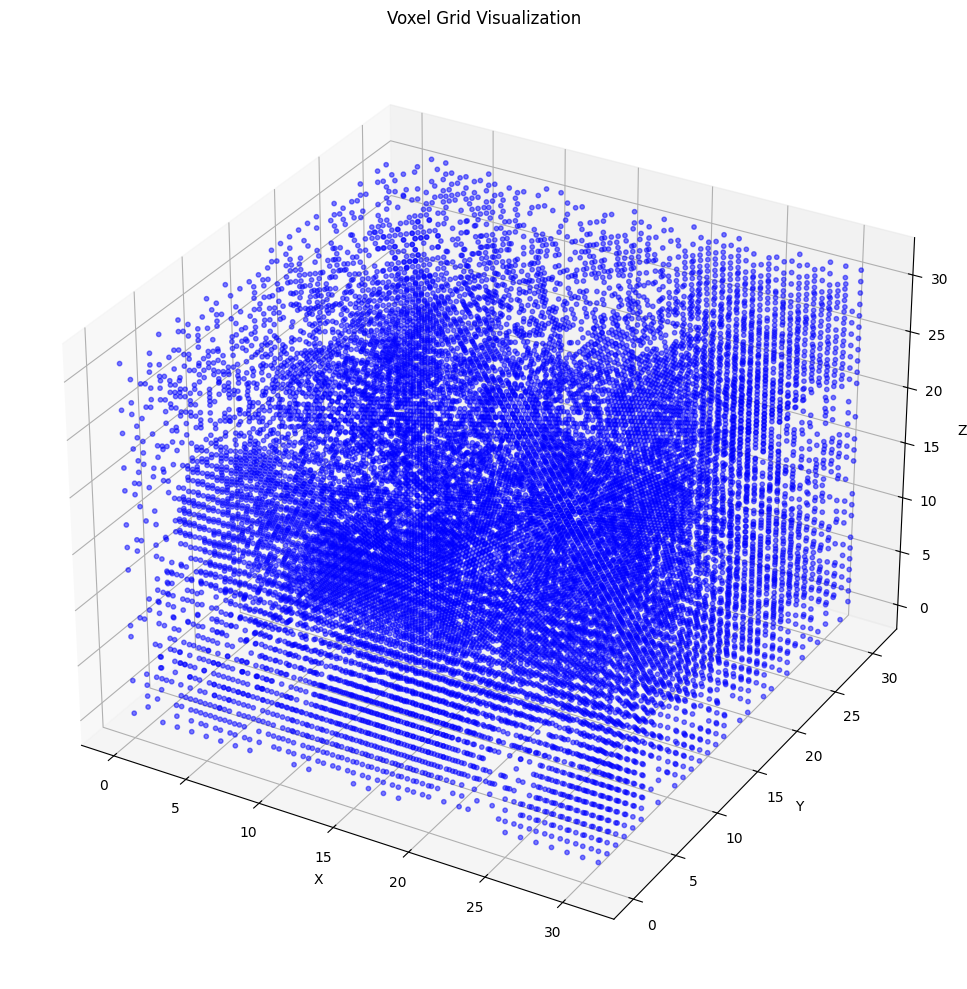

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 33283 vertices, 66337 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 33283 vertices, 66337 triangles.
Computing vertex normals...
Launching Open3D visualizer...
Visualizer window closed.
Prompt: ['A cube laptop']
--- Sampling from Diffusion Model
Loading model from: model_checkpoints/unet_epoch_30_1.pth
Diffusion model loaded successfully.
Generating samples...


Sampling loop time step:   0%|          | 0/800 [00:00<?, ?it/s]

Saved generated spectrogram to generated_models\model_1.pth
Sampling finished.


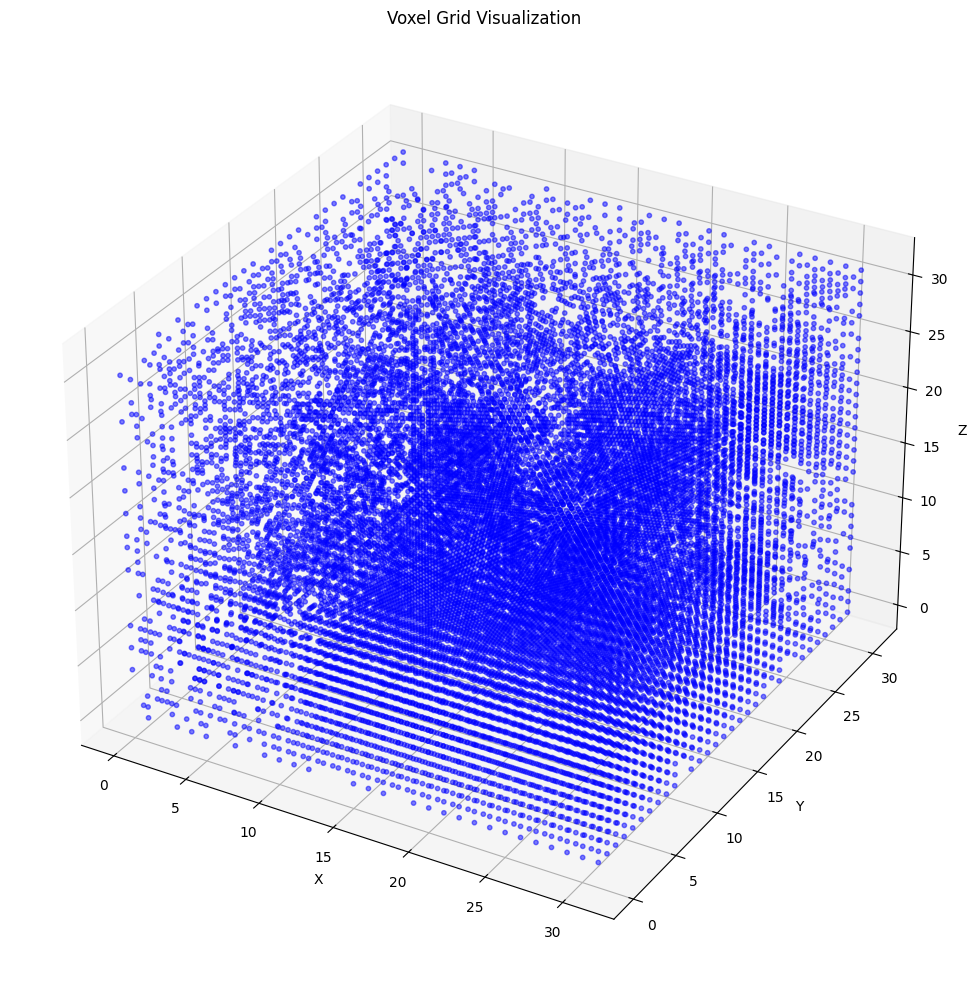

Loading voxel data from: generated_models\model_1.pth
Loaded data is a direct tensor.
Voxel tensor shape: torch.Size([1, 32, 32, 32])
Voxel tensor data type: torch.float32
Squeezed tensor shape from (1, 32, 32, 32) to (32, 32, 32)
Running marching cubes with isolevel = 0.0...
Generated mesh: 31083 vertices, 61738 faces.
Saving mesh to generated_models\output_mesh.obj...
Mesh saved successfully.
Attempting to load mesh from: generated_models\output_mesh.obj
Successfully loaded mesh: 31083 vertices, 61738 triangles.
Computing vertex normals...
Launching Open3D visualizer...
Visualizer window closed.
Prompt: ['round mug']


In [20]:

model_path = "model_checkpoints/unet_epoch_30_1.pth"

while(True):
    prompt = input("Enter a prompt (or 'exit' to quit): ")
    if prompt.lower() == 'exit':
        break
    else:
        prompt = [prompt]
        sample_and_visualize(CONFIG, prompt, model_path)
        print(f"Prompt: {prompt}")